# LOAD package

In [1]:
%pylab
from astropy.table import Table

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.integrate import quad,trapz
from scipy.special import gamma
from scipy.optimize import curve_fit

In [3]:
import seaborn as sns
sns.set()
# sns.set(rc={'figure.figsize':(15.7,9.27)})
# sns.set_style("ticks")

# LOAD data

## total nwp

### 直接观测得到的N

In [42]:
cen_bin = [11.4, 11.6, 11.8]
sate_bin = [9.0, 9.5, 10.0, 10.5,11.0]
rvir = np.array([681.3215717941365,846.2972450538917])/1000

In [43]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
# r_need = r_need[4:-2]
number = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        data = np.load("/home/yunzheng/PAC/code/PAC/0.3_0.5/LOWZ_CMASS_PAC/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = data[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
#         print(r_need_new)


        r_inter = (np.log10(rp_new[-1])+np.log10(rp_new[-2]))/2.0
        print("The inter r:",r_inter)

        
        r_need_inter = np.array([np.log10(r_need_new[-2]),np.log10(r_need_new[-1])])
        print("the inter rneed bin:",r_need_inter)

        
        nwp_inter = np.array([np.log10(nwp_new[-2]),np.log10(nwp_new[-1])])
        print("the nwp interbin:",10**nwp_inter)

        
        f = interp1d(r_need_inter,nwp_inter)
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],10**nwp_inter0))
        print("The nwp_inter:",10**nwp_inter0)

        
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        print("The number for each bin:")
        for k in range(len(rp_new)-1):
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k]
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number[i][j] = np.sum(N)
        
np.save("./all/original_num2.npy",number)

The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [2.94126141 1.61175793]
The nwp_inter: 2.0707847345985444
the nwp_new:
[12.60302393  7.32860886  4.08608576  2.94126141  2.07078473]
The number for each bin:
0.5986097731423233
0.8743606118635145
1.224549990266169
2.2141277100002155
0.42996504910331584
The total number:
5.341613134375539
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.67336782 1.02068133]
The nwp_inter: 1.2541195197144086
the nwp_new:
[9.09023055 5.31737899 2.9779363  1.67336782 1.25411952]
The number for each bin:
0.4317615263739374
0.6344050883896049
0.8924511344412096
1.2596806443887845
0.260397689757922
The total number:
3.4786960833514584
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.44197869 0.82476047]
The nwp_inter: 1.0409088063788228
the nwp_new:
[6.16591148 4.0887729  2.13796769 1.44197869 1.04090881]
The number for each bin:
0.2928642280123805


In [44]:
number

array([[ 5.34161313,  3.47869608,  2.72303283,  1.76803182],
       [10.19322937,  6.59853485,  5.050862  ,  3.54573777]])

### 计算修正比例

In [20]:
data[0][:7]

array([0.07943282, 0.12589254, 0.19952623, 0.31622777, 0.50118723,
       0.79432823, 1.25892541])

In [45]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
number_new = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0.3_0.5/LOWZ_CMASS_PAC/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        
        
        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        
        
        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y
        
        def func_wp1(rp,rvir0,r1,gam):
            y = quad(part_wp1,rp,rvir0,args = (rp,r1,gam))
            return y
        

###############calculate ratio###########
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = nwp[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
#         print(r_need_new)


        r_inter = (np.log10(rp_new[-1])+np.log10(rp_new[-2]))/2.0
        print("The inter r:",r_inter)

        
        r_need_inter = np.array([np.log10(r_need_new[-2]),np.log10(r_need_new[-1])])
        print("the inter rneed bin:",r_need_inter)

        
        nwp_inter = np.array([np.log10(nwp_new[-2]),np.log10(nwp_new[-1])])
        print("the nwp interbin:",10**nwp_inter)

        
        f = interp1d(r_need_inter,nwp_inter)
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],10**nwp_inter0))
        print("The nwp_inter:",10**nwp_inter0)


        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],popt[0],popt[1])
            print("The corr ratio:")
            print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr

        number_new[i][j] = np.sum(N)
np.save("./all/corr_num2.npy",number_new)

[0.66675726 2.10349443]
[0.00943489 0.04160043]
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [2.94126141 1.61175793]
The nwp_inter: 2.0707847345985444
The corr ratio:
0.9254302124437671
The corr ratio:
0.8753050762528474
The corr ratio:
0.7894546389554665
The corr ratio:
0.634020420517427
The corr ratio:
0.26286375798115275
[0.5535415  2.20556967]
[0.00225959 0.01364984]
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.67336782 1.02068133]
The nwp_inter: 1.2541195197144086
The corr ratio:
0.940418824016145
The corr ratio:
0.8955377389636385
The corr ratio:
0.8149604294620375
The corr ratio:
0.6619988219538528
The corr ratio:
0.27832186289929783
[0.48842854 2.09345782]
[0.00620284 0.04042547]
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.44197869 0.82476047]
The nwp_inter: 1.0409088063788228
The corr ratio:
0.9237600944538811
The corr ratio:
0.8731046604419528
The cor

In [46]:
number_new

array([[3.80285493, 2.6078642 , 1.94209579, 1.20711962],
       [7.94763677, 4.93080629, 3.78961628, 2.62621437]])

In [47]:
number

array([[ 5.34161313,  3.47869608,  2.72303283,  1.76803182],
       [10.19322937,  6.59853485,  5.050862  ,  3.54573777]])

In [48]:
number_new / number

array([[0.71193005, 0.74966716, 0.71321057, 0.68274768],
       [0.77969763, 0.74725775, 0.750291  , 0.74066796]])

## LOAD each field nwp

In [49]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)

m_sate = [9.0,9.5,10.0,10.5,11.0]
m_cen = [11.4,11.6,11.8]

jack=50
zs = ['0p35','0p45']

num0 = np.load("./all/original_num2.npy")
num1 = np.load("./all/corr_num2.npy")
fq_original = num1/num0


number = np.zeros((2,4,50))
for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        
        pcf = np.zeros((jack,len(r_need)))
        for k in range(len(zs)):
            data = np.load('/home/yunzheng/PAC/code/PAC/0.3_0.5/LOWZ_CMASS_PAC/%s_%.1f_%.1f_results_jack.npy' % (zs[k],m_cen[i],m_sate[j]))
            pcf+=data

        pcf = pcf/len(zs)
        
        
        for q in range(50):
            
            index = np.searchsorted(r,rvir[i])-1
            print("The index rvir:")
            print(index)
            print(r[index])


        
            nwp_new = pcf[q][1:index+1]
            rp_new = np.hstack((r[1:index+1],rvir[i]))
            r_need_new = r_need[1:index+1]
    #         print(r_need_new)


            r_inter = (np.log10(rp_new[-1])+np.log10(rp_new[-2]))/2.0
            print("The inter r:",r_inter)


            r_need_inter = np.array([np.log10(r_need_new[-2]),np.log10(r_need_new[-1])])
            print("the inter rneed bin:",r_need_inter)


            nwp_inter = np.array([np.log10(nwp_new[-2]),np.log10(nwp_new[-1])])
            print("the nwp interbin:",10**nwp_inter)


            f = interp1d(r_need_inter,nwp_inter)
            nwp_inter0 = f(r_inter)
            nwp_new = np.hstack((nwp_new[:-1],10**nwp_inter0))
            print("The nwp_inter:",10**nwp_inter0)


            N = np.zeros(len(rp_new)-1)
            for p in range(len(rp_new)-1):
                N[p] = np.pi * (rp_new[p+1]**2-rp_new[p]**2) * nwp_new[p] * fq_original[i][j]

            print("The total number:")
            print(np.sum(N))
            
            number[i][j][q] = np.sum(N)
np.save("./all/eachfield_result2.npy",number)

The index rvir:
5
0.6309573444801934
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [2.96104359 1.63963603]
The nwp_inter: 2.097454807652873
The total number:
3.7994836803575716
The index rvir:
5
0.6309573444801934
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [2.91023491 1.62395177]
The nwp_inter: 2.070740918789436
The total number:
3.734108902525674
The index rvir:
5
0.6309573444801934
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [2.96731007 1.59303051]
The nwp_inter: 2.0642830280361304
The total number:
3.8025633703609985
The index rvir:
5
0.6309573444801934
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [2.98479196 1.65604316]
The nwp_inter: 2.11670642735633
The total number:
3.844512424387185
The index rvir:
5
0.6309573444801934
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [2.94625265 1.62

# red galaxy 

## all red galaxy

In [50]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
# r_need = r_need[4:-2]
number = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        data = np.load("/home/yunzheng/PAC/code/PAC/0.3_0.5/color_cut_red/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = data[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
#         print(r_need_new)


        r_inter = (np.log10(rp_new[-1])+np.log10(rp_new[-2]))/2.0
        print("The inter r:",r_inter)

        
        r_need_inter = np.array([np.log10(r_need_new[-2]),np.log10(r_need_new[-1])])
        print("the inter rneed bin:",r_need_inter)

        
        nwp_inter = np.array([np.log10(nwp_new[-2]),np.log10(nwp_new[-1])])
        print("the nwp interbin:",10**nwp_inter)

        
        f = interp1d(r_need_inter,nwp_inter)
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],10**nwp_inter0))
        print("The nwp_inter:",10**nwp_inter0)

        
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        print("The number for each bin:")
        for k in range(len(rp_new)-1):
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k]
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number[i][j] = np.sum(N)
        
np.save("./red_galaxy/original_num2.npy",number)

The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.14746825 0.6091133 ]
The nwp_inter: 0.7930238176596528
the nwp_new:
[6.65056915 3.99033073 1.69642131 1.14746825 0.79302382]
The number for each bin:
0.31588416517202916
0.4760778044475324
0.5083967461666472
0.8637930754196274
0.16465860453922784
The total number:
2.3288103957450637
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [0.74662411 0.54760842]
The nwp_inter: 0.6231038153715641
the nwp_new:
[6.13763855 3.60971233 1.72462838 0.74662411 0.62310382]
The number for each bin:
0.29152133991177626
0.4306670397702812
0.5168500585286191
0.5620449539337535
0.12937745681452364
The total number:
1.9304608489589536
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.12633124 0.6292161 ]
The nwp_inter: 0.8019529642203715
the nwp_new:
[5.25428976 3.33944867 1.61047085 1.12633124 0.80195296]
The number for each bin:
0.2495646456997428

## 修正比例

In [51]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
number_new = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0.3_0.5/color_cut_red/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        
        
        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        
        
        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y
        
        def func_wp1(rp,rvir0,r1,gam):
            y = quad(part_wp1,rp,rvir0,args = (rp,r1,gam))
            return y
        

###############calculate ratio###########
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = nwp[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
#         print(r_need_new)


        r_inter = (np.log10(rp_new[-1])+np.log10(rp_new[-2]))/2.0
        print("The inter r:",r_inter)

        
        r_need_inter = np.array([np.log10(r_need_new[-2]),np.log10(r_need_new[-1])])
        print("the inter rneed bin:",r_need_inter)

        
        nwp_inter = np.array([np.log10(nwp_new[-2]),np.log10(nwp_new[-1])])
        print("the nwp interbin:",10**nwp_inter)

        
        f = interp1d(r_need_inter,nwp_inter)
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],10**nwp_inter0))
        print("The nwp_inter:",10**nwp_inter0)


        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],popt[0],popt[1])
            print("The corr ratio:")
            print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr

        number_new[i][j] = np.sum(N)
np.save("./red_galaxy/corr_num2.npy",number_new)

[0.46191927 2.35175549]
[0.00915028 0.07296107]
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.14746825 0.6091133 ]
The nwp_inter: 0.7930238176596528
The corr ratio:
0.9566844959954637
The corr ratio:
0.9187302127042252
The corr ratio:
0.8458322831253766
The corr ratio:
0.6977383357419771
The corr ratio:
0.2991466235672798
[0.43786511 2.42924826]
[0.00826671 0.07451706]
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [0.74662411 0.54760842]
The nwp_inter: 0.6231038153715641
The corr ratio:
0.9633801849339343
The corr ratio:
0.9287805332406203
The corr ratio:
0.8599056972239068
The corr ratio:
0.7148632213985704
The corr ratio:
0.3096248103374412
[0.44014019 2.15715532]
[0.00714996 0.05422462]
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.12633124 0.6292161 ]
The nwp_inter: 0.8019529642203715
The corr ratio:
0.9337406150655746
The corr ratio:
0.8864086653466043
The cor

## each field

In [52]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)

m_sate = [9.0,9.5,10.0,10.5,11.0]
m_cen = [11.4,11.6,11.8]

jack=50
zs = ['0p35','0p45']

num0 = np.load("./red_galaxy/original_num2.npy")
num1 = np.load("./red_galaxy/corr_num2.npy")
fq_original = num1/num0


number = np.zeros((2,4,50))
for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        
        pcf = np.zeros((jack,len(r_need)))
        for k in range(len(zs)):
            data = np.load('/home/yunzheng/PAC/code/PAC/0.3_0.5/color_cut_red/%s_%.1f_%.1f_results_jack.npy' % (zs[k],m_cen[i],m_sate[j]))
            pcf+=data

        pcf = pcf/len(zs)
        
        
        for q in range(50):
            
            index = np.searchsorted(r,rvir[i])-1
            print("The index rvir:")
            print(index)
            print(r[index])


        
            nwp_new = pcf[q][1:index+1]
            rp_new = np.hstack((r[1:index+1],rvir[i]))
            r_need_new = r_need[1:index+1]
    #         print(r_need_new)


            r_inter = (np.log10(rp_new[-1])+np.log10(rp_new[-2]))/2.0
            print("The inter r:",r_inter)


            r_need_inter = np.array([np.log10(r_need_new[-2]),np.log10(r_need_new[-1])])
            print("the inter rneed bin:",r_need_inter)


            nwp_inter = np.array([np.log10(nwp_new[-2]),np.log10(nwp_new[-1])])
            print("the nwp interbin:",10**nwp_inter)


            f = interp1d(r_need_inter,nwp_inter)
            nwp_inter0 = f(r_inter)
            nwp_new = np.hstack((nwp_new[:-1],10**nwp_inter0))
            print("The nwp_inter:",10**nwp_inter0)


            N = np.zeros(len(rp_new)-1)
            for p in range(len(rp_new)-1):
                N[p] = np.pi * (rp_new[p+1]**2-rp_new[p]**2) * nwp_new[p] * fq_original[i][j]

            print("The total number:")
            print(np.sum(N))
            
            number[i][j][q] = np.sum(N)
np.save("./red_galaxy/eachfield_result2.npy",number)

The index rvir:
5
0.6309573444801934
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.15742557 0.63176361]
The nwp_inter: 0.8130175834674974
The total number:
1.8333498763348364
The index rvir:
5
0.6309573444801934
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.11752902 0.60058654]
The nwp_inter: 0.7779128066222121
The total number:
1.7668754788848513
The index rvir:
5
0.6309573444801934
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.15082957 0.59681841]
The nwp_inter: 0.7846015074822829
The total number:
1.797926349736425
The index rvir:
5
0.6309573444801934
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.16908301 0.63924408]
The nwp_inter: 0.8220447952580652
The total number:
1.8332894131025552
The index rvir:
5
0.6309573444801934
The inter r: -0.18332393017227586
the inter rneed bin: [-0.3 -0.1]
the nwp interbin: [1.15798372

# result

In [53]:
red_num = np.load("./red_galaxy/eachfield_result2.npy")
all_num = np.load("./all/eachfield_result2.npy")

In [59]:
result = np.mean(red_num / all_num,axis = 2) 

In [60]:
result

array([[0.47899583, 0.60091108, 0.80808032, 0.91673207],
       [0.50828277, 0.63872944, 0.8204409 , 0.94234392]])

In [56]:
sigma = np.sqrt(49) * np.std(red_num / all_num,axis = -1) 

In [61]:
np.save("./result2.npy",np.array([result,sigma]))

(0.45, 1.02)

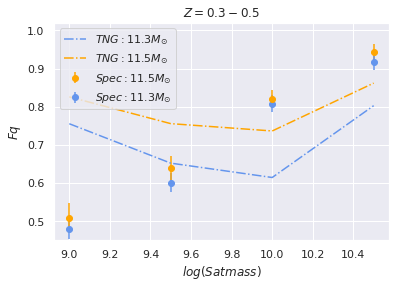

In [62]:
cen_bin = [11.3, 11.5, 11.7]
sate_bin = [9.0, 9.5, 10.0, 10.5,11.0]
color0 = ['cornflowerblue','orange']   #######e','seagreen',
for i in range(2):
    for j in range(4):
       
        if j==3:
            continue
        data = np.load("./result2.npy")
        plt.errorbar(sate_bin[j],data[0][i][j],data[1][i][j],color = color0[i],fmt = 'o')
plt.errorbar(sate_bin[-2],data[0][1][3],data[1][1][3],color = color0[1],fmt = 'o',label = "$Spec : %s M_{\odot}$"%cen_bin[1])
plt.errorbar(sate_bin[3],data[0][0][3],data[1][0][3],color = color0[0],fmt = 'o',label = "$Spec : %s M_{\odot}$"%cen_bin[0])

TNG = np.load("./TNG_fq.npz")
plt.plot(sate_bin[:-1],TNG['version2'][0],color = color0[0],linestyle = '-.',label = "$TNG : 11.3 M_{\odot}$")
plt.plot(sate_bin[:-1],TNG['version2'][1],color = color0[1],linestyle = '-.',label = "$TNG : 11.5 M_{\odot}$")


plt.xlabel("$log(Sat mass)$")
plt.ylabel("$Fq$")
plt.legend(loc = "upper left")
plt.title("$Z = 0.3 - 0.5$")
plt.ylim(0.45,1.02)
# plt.plot()
# plt.savefig("/home/yunzheng/PAC/picture/PCF_colorcut/Fq_0.3.pdf",dpi = 100)